In [1]:
# conda activate realtime

# import packages and data

import sys
#!pip install moscot
#import moscot
import matplotlib.pyplot as plt
# warnings
import warnings
# from matplotlib.errors import MatplotlibDeprecationWarning

# warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)
# warnings.filterwarnings(
#     action="ignore", module="matplotlib", message="'matplotlib.cbook' has no attribute 'mplDeprecation'"
# )
from moscot.problems.time import TemporalProblem
import moscot.plotting as mtp
import cellrank as cr
import scanpy as sc
from cellrank.kernels import RealTimeKernel

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

In [2]:
data_dir = "/w5home/bmoore/scRNAseq/GAMM/output_seuratintegrate_20241004_125959/"
# get adata
adata = sc.read_h5ad(data_dir + "merged_seurat2.h5ad")
adata

AnnData object with n_obs × n_vars = 35990 × 31781
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'percent.mt', 'sizeFactors', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.5', 'seurat_clusters', 'CellType', 'CellType_manual', 'predicted.id', 'prediction.score.Prog', 'prediction.score.iMG', 'prediction.score.PR', 'prediction.score.AC', 'prediction.score.HC', 'prediction.score.Prog.Glia', 'prediction.score.RGC', 'prediction.score.BC', 'prediction.score.max', 'predicted.celltype.score', 'predicted.celltype', 'nCount_RNA5', 'nFeature_RNA5', 'CellType_combined', 'orig.ident2'
    var: 'vf_vst_counts.GAMM_40_mean', 'vf_vst_counts.GAMM_40_variance', 'vf_vst_counts.GAMM_40_variance.expected', 'vf_vst_counts.GAMM_40_variance.standardized', 'vf_vst_counts.GAMM_40_variable', 'vf_vst_counts.GAMM_40_rank', 'vf_vst_counts.GAMM_120_mean', 'vf_vst_counts.GAMM_120_variance', 'vf_vs

In [7]:
import anndata
import h5py
import numpy as np
import os

#data_dir = os.path.expanduser("/w5home/bmoore/scRNAseq_downstream/data/gamm_data/output_seuratintegrate_20241004_125959/")
# Load the converted AnnData object
#adata = anndata.read_h5ad(data_dir +"merged_seurat2.h5ad")
# Open the original h5Seurat file
with h5py.File(data_dir + "seurat_obj_merged2.h5Seurat", "r") as f:
    print(f)
    # Extract the integrated_cca data and transpose it
    integrated_cca = f["integrated.cca1"][:].T
# Add the integrated.cca component
adata.obsm["X_integrated_cca"] = integrated_cca
adata.write_h5ad(data_dir +"merged_seurat2_with_integrated_cca2.h5ad")

<HDF5 file "seurat_obj_merged2.h5Seurat" (mode r)>


In [8]:
integrated_cca.shape

(35990, 50)

In [9]:
adata.obsm

AxisArrays with keys: X_umap, X_integrated_cca

In [35]:

adata.obs["time"] = adata.obs["orig.ident2"]#.astype(float).astype("category")
print(adata.obs["time"].unique())
#categories = [1,2,3,4,5,6]
#adata.obs["time"].cat.categories = ["1","2","3","4","5","6"]
#adata.obs["time_numerical"] = adata.obs["time"].astype(float)

['GAMM_40', 'GAMM_120']
Categories (2, object): ['GAMM_40', 'GAMM_120']


In [36]:
# replacing values
adata.obs["time"].replace(['GAMM_40', 'GAMM_120'],[1, 2], inplace=True)
print(adata.obs["time"].unique())

[1, 2]
Categories (2, int64): [1, 2]


In [37]:
adata.obs["time"] = adata.obs["time"].astype(float).astype("category")
print(adata.obs["time"].unique())

[1.0, 2.0]
Categories (2, float64): [1.0, 2.0]


In [38]:
adata.obs["CellType_combined"] = adata.obs["CellType_combined"].astype("string").astype("category")
print(adata.obs["CellType_combined"].unique())

['Retinal Prog', 'Cone', 'Ganglion Cell', 'unknown', 'Muller Glia-Retinal Prog', 'Rod', 'Muller Glia', 'Bipolar Cells', 'Muller Glia-Rod', 'Amacrine Cell']
Categories (10, string): [Amacrine Cell, Bipolar Cells, Cone, Ganglion Cell, ..., Muller Glia-Rod, Retinal Prog, Rod, unknown]


In [39]:
# visualize this data using the original force-directed layout
# force directed layout 
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
sc.tl.draw_graph(adata, layout='fa')


         Falling back to preprocessing with `sc.pp.pca` and default params.


/w5home/bmoore/miniconda3/envs/realtime/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/w5home/bmoore/miniconda3/envs/realtime/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_3725264/3318075364.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


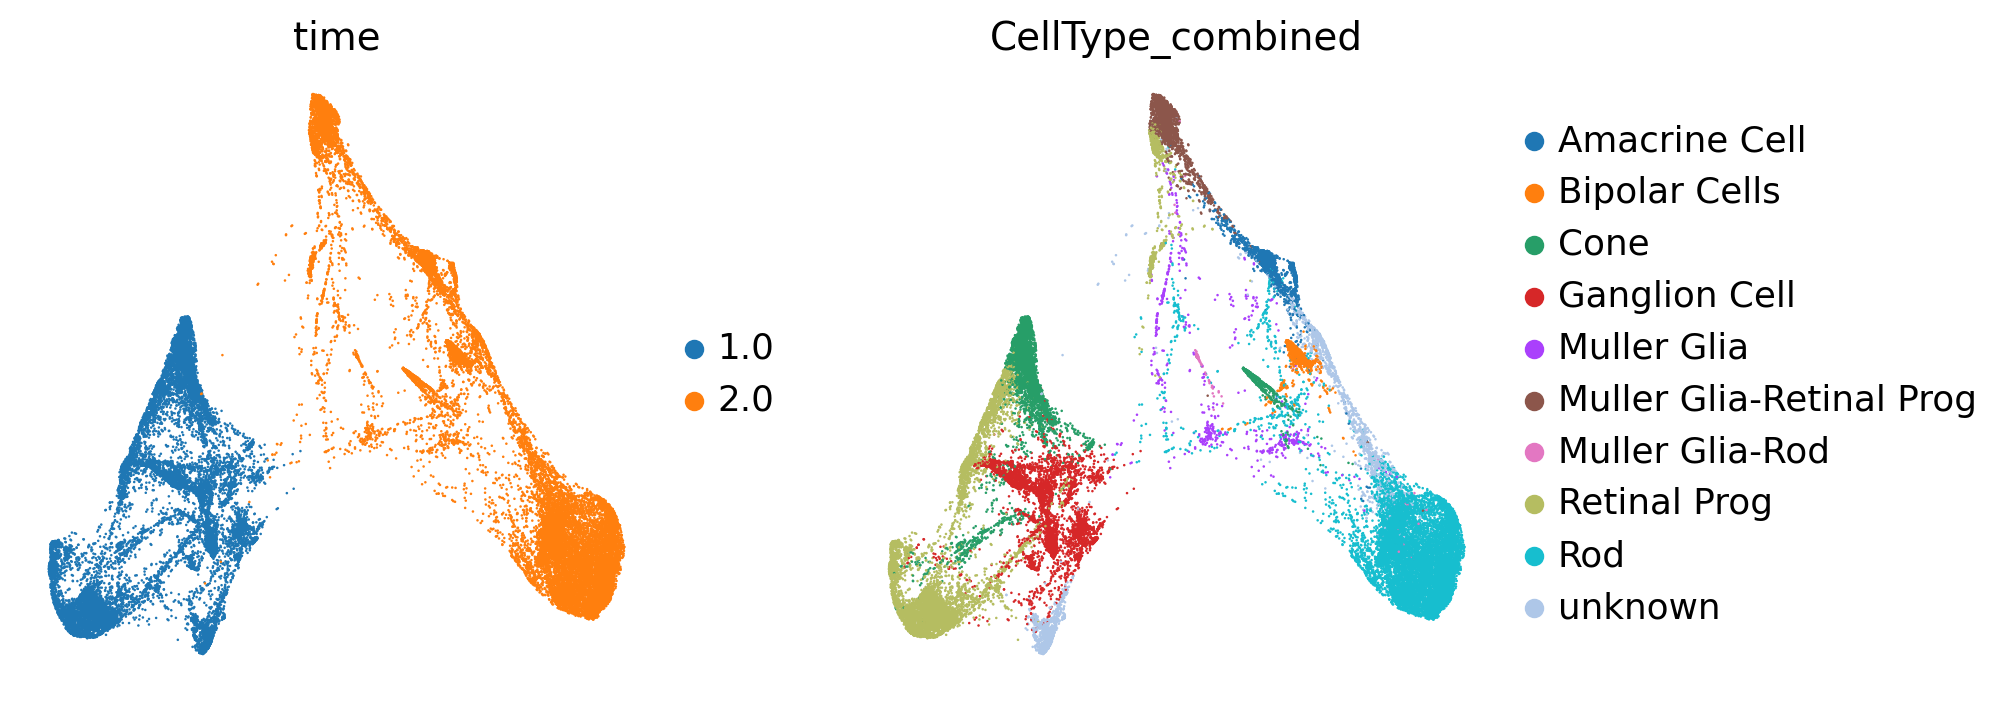

In [40]:
with plt.rc_context():
    sc.pl.embedding(
        adata,
        basis="X_draw_graph_fa",
        color=["time", "CellType_combined"],
        color_map="gnuplot",
        show=False)
    plt.tight_layout()
    plt.savefig(out_dir + "force_directed_graph.pdf", bbox_inches='tight')

In [41]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: X_umap, X_integrated_cca, X_pca, X_draw_graph_fa)


In [42]:
# get proliferation and apopstosis genes
import moscot as mt
from moscot.utils.data import proliferation_markers, apoptosis_markers
p_markers = proliferation_markers("human")
a_markers = apoptosis_markers("human")
print(p_markers,a_markers)
type(p_markers)

['ANLN', 'ANP32E', 'ATAD2', 'AURKA', 'AURKB', 'BIRC5', 'BLM', 'BRIP1', 'BUB1', 'CASP8AP2', 'CBX5', 'CCNB2', 'CCNE2', 'CDC20', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDCA3', 'CDCA7', 'CDCA8', 'CDK1', 'CENPA', 'CENPE', 'CENPF', 'CHAF1B', 'CKAP2', 'CKAP2L', 'CKAP5', 'CKS1B', 'CKS2', 'CLSPN', 'CTCF', 'DLGAP5', 'DSCC1', 'DTL', 'E2F8', 'ECT2', 'EXO1', 'FAM64A', 'FEN1', 'G2E3', 'GAS2L3', 'GINS2', 'GMNN', 'GTSE1', 'HELLS', 'HJURP', 'HMGB2', 'HMMR', 'HN1', 'KIF11', 'KIF20B', 'KIF23', 'KIF2C', 'LBR', 'MCM2', 'MCM4', 'MCM5', 'MCM6', 'MKI67', 'MLF1IP', 'MSH2', 'NASP', 'NCAPD2', 'NDC80', 'NEK2', 'NUF2', 'NUSAP1', 'PCNA', 'POLA1', 'POLD3', 'PRIM1', 'PSRC1', 'RAD51', 'RAD51AP1', 'RANGAP1', 'RFC2', 'RPA2', 'RRM1', 'RRM2', 'SLBP', 'SMC4', 'TACC3', 'TIPIN', 'TMPO', 'TOP2A', 'TPX2', 'TTK', 'TUBB4B', 'TYMS', 'UBE2C', 'UBR7', 'UHRF1', 'UNG', 'USP1', 'WDR76'] ['ADD1', 'AIFM3', 'ANKH', 'ANXA1', 'APP', 'ATF3', 'AVPR1A', 'BAX', 'BCAP31', 'BCL10', 'BCL2L1', 'BCL2L10', 'BCL2L11', 'BCL2L2', 'BGN', 'BID', 'BIK', 'BI

list

In [43]:
gene_pool = list(adata.var_names)
print(gene_pool)

['ALDH1A1', 'ANXA1', 'RORB', 'TRPM6', 'C9orf40', 'CARNMT1', 'NMRK1', 'OSTF1', 'ENSSSCG00000045514', 'PCSK5', 'ENSSSCG00000057774', 'RFK', 'GCNT1', 'ENSSSCG00000039009', 'ENSSSCG00000060679', 'ENSSSCG00000005279', 'VPS13A', 'GRIK2', 'COQ3', 'LMBRD1', 'PNISR', 'COL19A1', 'ENSSSCG00000004261', 'ENSSSCG00000050732', 'USP45', 'KPNA5', 'ENSSSCG00000038757', 'CCNC', 'GNA14', 'ENSSSCG00000050902', 'ZUP1', 'ABHD17B', 'C9orf85', 'PRDM13', 'ENSSSCG00000004355', 'GDA', 'RSPH4A', 'ENSSSCG00000032533', 'ENSSSCG00000031854', 'PTP4A1', 'MCHR2', 'ZFAND5', 'KLHL32', 'ENSSSCG00000004243', 'TMC1', 'ENSSSCG00000004246', 'ASF1A', 'CEP85L', 'TLE4', 'TXNDC16', 'ENSSSCG00000044405', 'PLN', 'GPR137C', 'GJA1', 'ERO1A', 'TBC1D32', 'ENSSSCG00000035799', 'ENSSSCG00000044458', 'TLE1', 'PSMC6', 'ENSSSCG00000028308', 'FAM184A', 'ENSSSCG00000033805', 'ENSSSCG00000037497', 'GNAQ', 'MMS22L', 'CEP78', 'COL9A1', 'STYX', 'GNPNAT1', 'SLC35F1', 'PSAT1', 'FERMT2', 'NUS1', 'ENSSSCG00000058846', 'ENSSSCG00000004252', 'ENSSSCG000

In [44]:
'CDC20' in [str(i) for i in adata.var_names]

True

In [45]:
# Reconstruct differentiation trajectory across time points using moscot

# With moscot, we couple cells across time points using optimal transport (OT) by setting up the temporal problem.
tp = TemporalProblem(adata)
# Next, we adjust the marginals for cellular growth- and death rates.
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human",use_raw=False
)


/w5home/bmoore/miniconda3/envs/realtime/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_3725264/1901755499.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


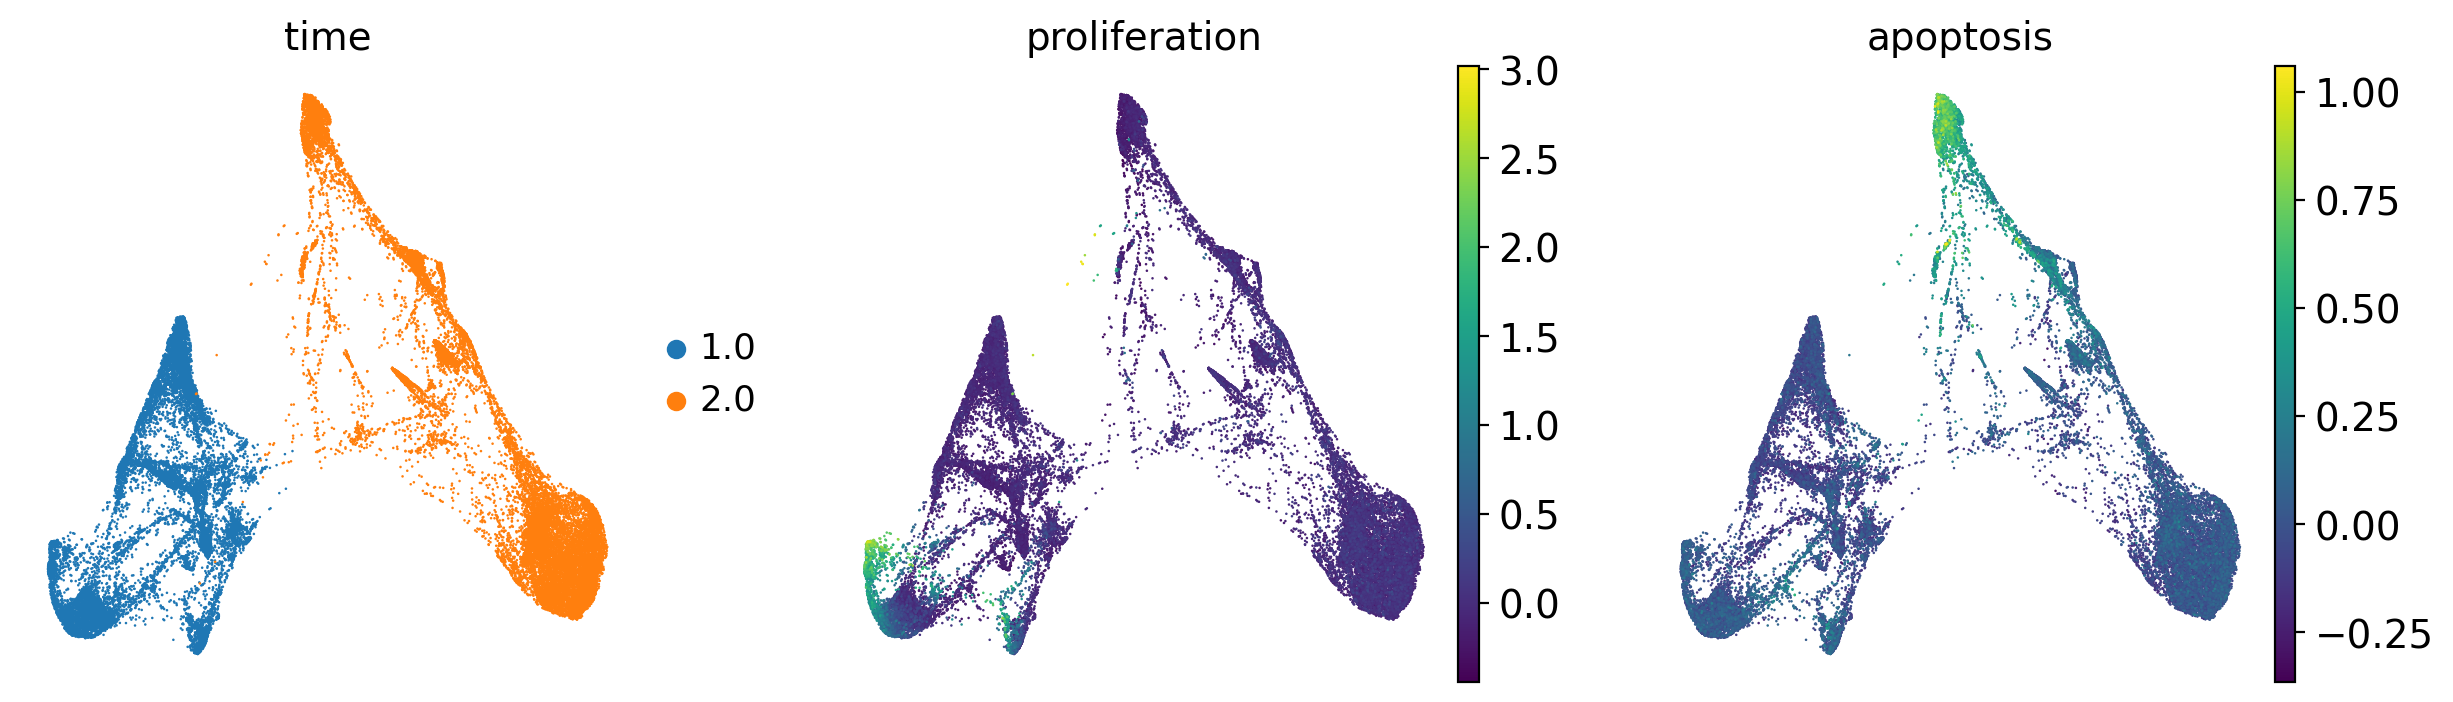

In [46]:
# visualize the proliferation and apoptosis scores
with plt.rc_context():
    sc.pl.embedding(
        adata, basis="X_draw_graph_fa", color=["time", "proliferation", "apoptosis"],
        show=False)
    plt.tight_layout()
    plt.savefig(out_dir + "prolif-apop_graph.pdf", bbox_inches='tight')

In [47]:
# Following the original Waddington OT publication, we use local PCAs, computed separately for each pair of time points, to calulate distances among cells.
tp = tp.prepare(time_key="time", joint_attr="X_integrated_cca", marginal_kwargs={"scaling": 2})

INFO     Ordering Index(['seurat_obj_labeled_S1_AAACCCAAGCCTCCAG_1',                                               
                'seurat_obj_labeled_S1_AAACCCAAGCGACCCT_1',                                                        
                'seurat_obj_labeled_S1_AAACCCAAGGTGCGAT_1',                                                        
                'seurat_obj_labeled_S1_AAACCCACAACTTGCA_1',                                                        
                'seurat_obj_labeled_S1_AAACCCACACATACGT_1',                                                        
                'seurat_obj_labeled_S1_AAACCCACAGACTGCC_1',                                                        
                'seurat_obj_labeled_S1_AAACCCACAGCTGTCG_1',                                                        
                'seurat_obj_labeled_S1_AAACCCAGTACTCGTA_1',                                                        
                'seurat_obj_labeled_S1_AAACCCATCCGTCCTA_1',             

In [48]:
# We solve one OT problem per time point pair, probabilistically matching early to late cells.

tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")
# Above, epsilon and tau_a control the amount of entropic regularization and unbalancedness on the source marginal, respectively. 
# Higher entropic regularization speeds up the optimization and improves statistical properties of the solution [Cuturi, 2013]; 
# unbalancedness makes the solution more robust with respect to uncertain cellular growth rates and biased cell sampling

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(16654, 19336)].                                


In [51]:
# compare prior and posterior growth rates
adata.obs["prior_growth_rates"] = tp.prior_growth_rates
adata.obs["posterior_growth_rates"] = tp.posterior_growth_rates

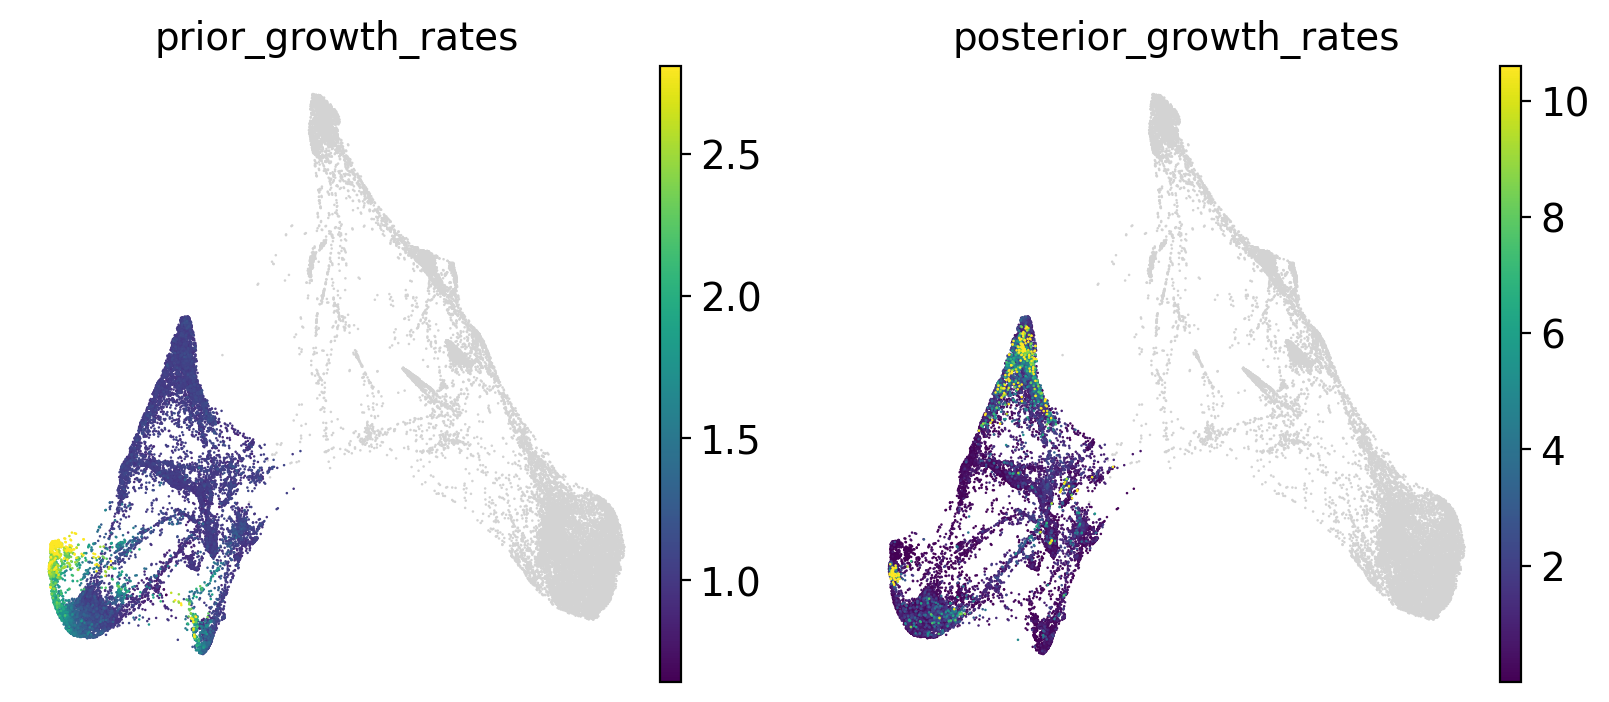

In [52]:
sc.pl.embedding(
    adata,
    basis="X_draw_graph_fa",
    color=["prior_growth_rates", "posterior_growth_rates"],
    vmax="p99",
)

In [53]:
# add cell costs
# High values indicate that a certain cell is unlikely to have a descendant or ancestor
adata.obs["cell_costs_source"] = tp.cell_costs_source
adata.obs["cell_costs_target"] = tp.cell_costs_target

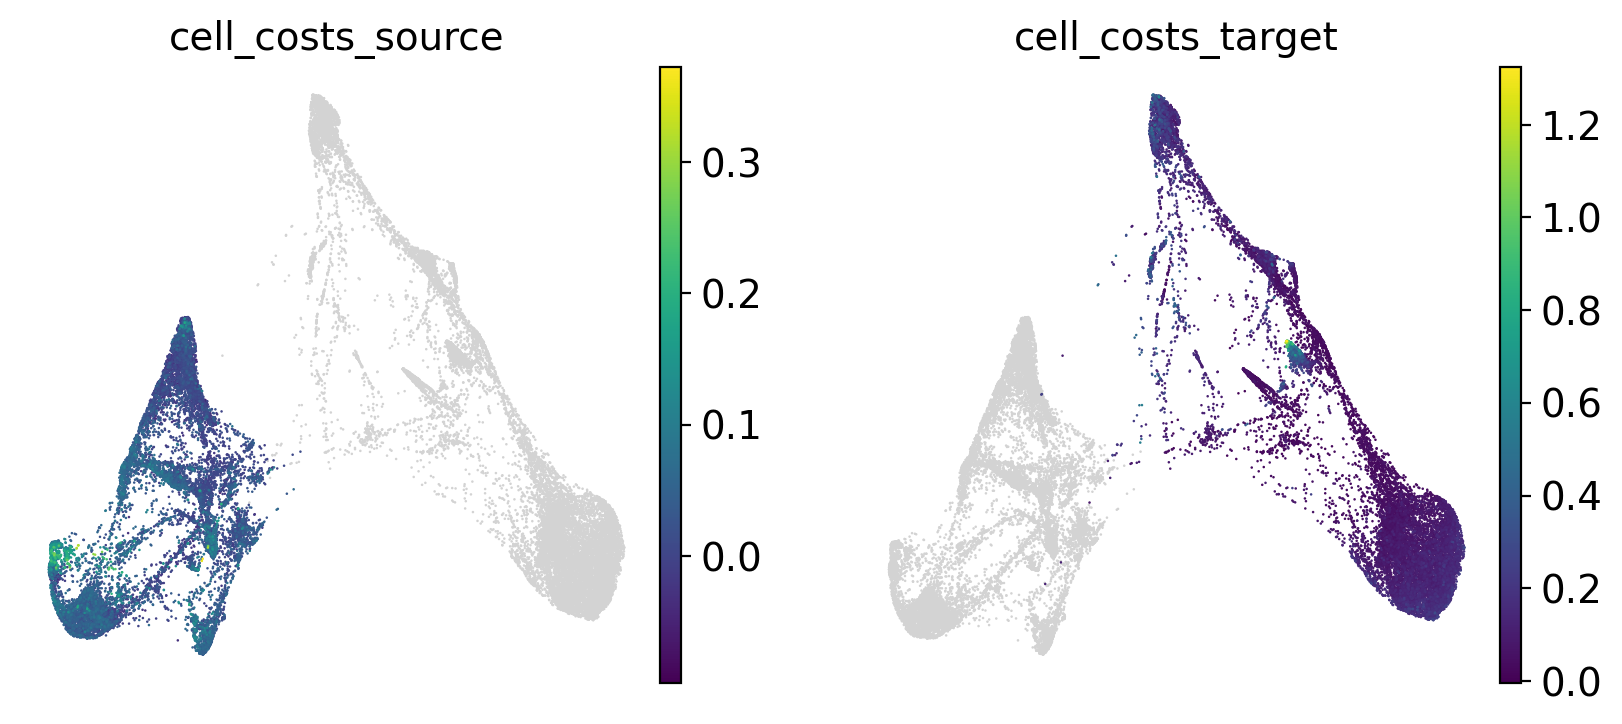

In [54]:
# visulaize cell costs
sc.pl.embedding(
    adata, basis="X_draw_graph_fa", color=["cell_costs_source", "cell_costs_target"]
)

In [63]:
# identfy ancestry of cells
# investigate which ancestry population a certain cell type has. We do this by aggregating the transport matrix by cell type, using cell_transition()
# forward=True means we are plotting descendents, forward=False means we are plotting ancestors

tp.cell_transition(
    source=1, 
    target=2, 
    source_groups="CellType_combined", 
    target_groups="CellType_combined", 
    forward=True, 
    key_added="transitions_1_2"
)
# tp.cell_transition(
#     source=2, 
#     target=3, 
#     source_groups="seurat_clusters", 
#     target_groups="seurat_clusters", 
#     forward=True, 
#     key_added="transitions_2_3"
# )
# tp.cell_transition( 
#     source=3, 
#     target=4, 
#     source_groups="seurat_clusters", 
#     target_groups="seurat_clusters", 
#     forward=True, 
#     key_added="transitions_3_4"
# )  
# tp.cell_transition(
#     source=4, 
#     target=5, 
#     source_groups="seurat_clusters", 
#     target_groups="seurat_clusters", 
#     forward=True, 
#     key_added="transitions_4_5"
# )
# tp.cell_transition(
#     source=5, 
#     target=6, 
#     source_groups="seurat_clusters", 
#     target_groups="seurat_clusters", 
#     forward=True, 
#     key_added="transitions_5_6"
# )

Rod  Bipolar Cells          Cone  \
Ganglion Cell  0.178770       0.130485  1.687566e-31   
Cone           0.801955       0.050402  5.558904e-02   
Retinal Prog   0.459678       0.014398  2.882623e-16   
unknown        0.097979       0.002657  0.000000e+00   

               Muller Glia-Retinal Prog  Retinal Prog  Amacrine Cell  \
Ganglion Cell                  0.007818      0.010118       0.425257   
Cone                           0.002689      0.000107       0.005627   
Retinal Prog                   0.331158      0.124263       0.041195   
unknown                        0.057448      0.037797       0.103376   

               Muller Glia  Muller Glia-Rod   unknown  
Ganglion Cell     0.095702         0.003362  0.148488  
Cone              0.002181         0.003023  0.078426  
Retinal Prog      0.003369         0.016035  0.009905  
unknown           0.643673         0.001000  0.056069

In [59]:
adata.obs["CellType_combined"].unique()

['Retinal Prog', 'Cone', 'Ganglion Cell', 'unknown', 'Muller Glia-Retinal Prog', 'Rod', 'Muller Glia', 'Bipolar Cells', 'Muller Glia-Rod', 'Amacrine Cell']
Categories (10, string): [Amacrine Cell, Bipolar Cells, Cone, Ganglion Cell, ..., Muller Glia-Rod, Retinal Prog, Rod, unknown]

In [64]:
adata.uns['moscot_results']['cell_transition']

{'transitions_RetinalProg_Cone': {'source': 1,
  'target': 2,
  'source_groups': 'CellType_combined',
  'target_groups': 'CellType_combined',
  'transition_matrix':                     Rod  Bipolar Cells          Cone  \
  Ganglion Cell  0.178770       0.130485  1.687566e-31   
  Cone           0.801955       0.050402  5.558904e-02   
  Retinal Prog   0.459678       0.014398  2.882623e-16   
  unknown        0.097979       0.002657  0.000000e+00   
  
                 Muller Glia-Retinal Prog  Retinal Prog  Amacrine Cell  \
  Ganglion Cell                  0.007818      0.010118       0.425257   
  Cone                           0.002689      0.000107       0.005627   
  Retinal Prog                   0.331158      0.124263       0.041195   
  unknown                        0.057448      0.037797       0.103376   
  
                 Muller Glia  Muller Glia-Rod   unknown  
  Ganglion Cell     0.095702         0.003362  0.148488  
  Cone              0.002181         0.003023  0.078426

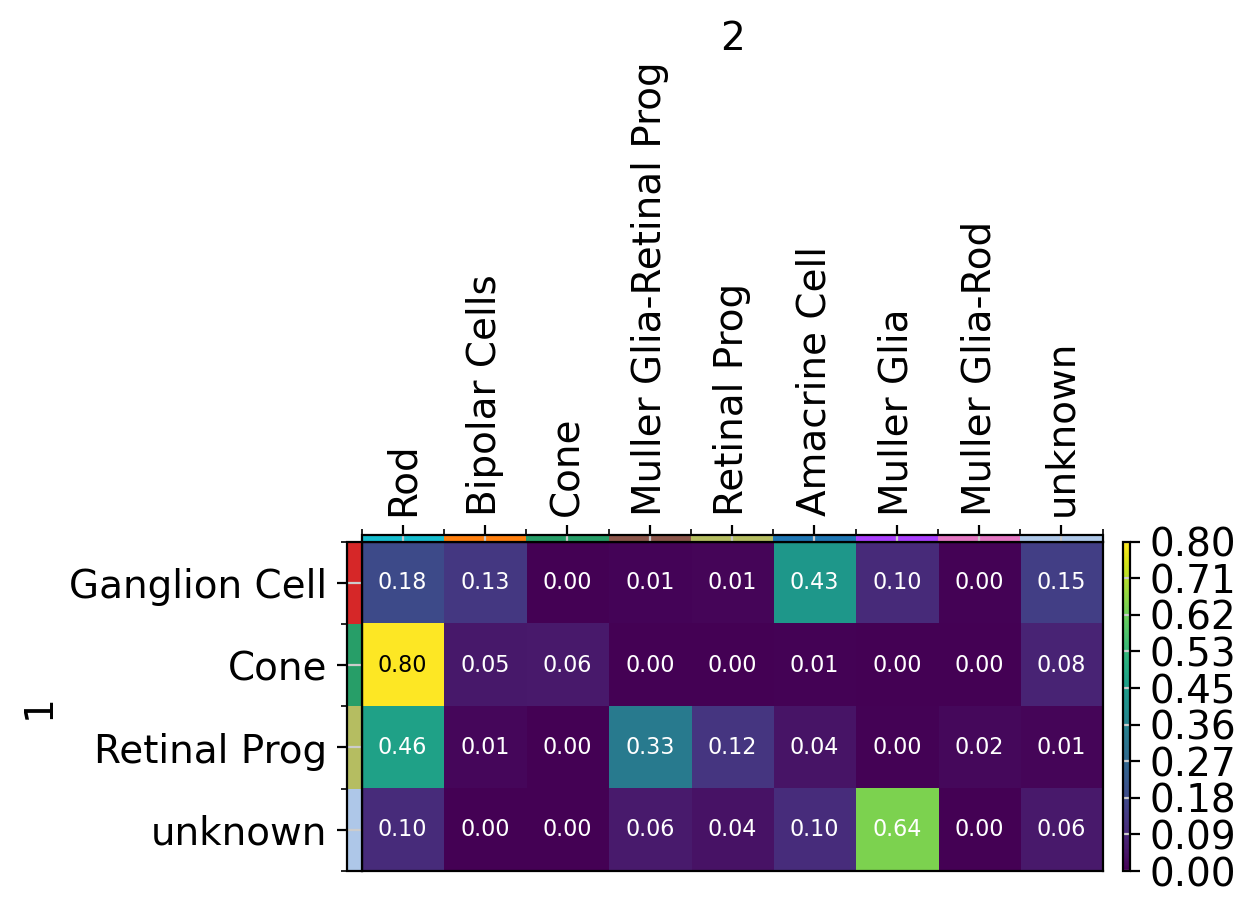

In [65]:
# Create plots
mtp.cell_transition(adata, key="transitions_1_2", dpi=100, fontsize=8, save=out_dir + "transitions_heatmap_1-2.png")
# mtp.cell_transition(adata, key="transitions_2_3", dpi=100, fontsize=8, save=out_dir + "transitions_heatmap_2-3.png")
# mtp.cell_transition(adata, key="transitions_3_4", dpi=100, fontsize=8, save=out_dir + "transitions_heatmap_3-4.png")
# mtp.cell_transition(adata, key="transitions_4_5", dpi=100, fontsize=8, save=out_dir + "transitions_heatmap_4-5.png")
# mtp.cell_transition(adata, key="transitions_5_6", dpi=100, fontsize=8, save=out_dir + "transitions_heatmap_5-6.png")

/w5home/bmoore/miniconda3/envs/realtime/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


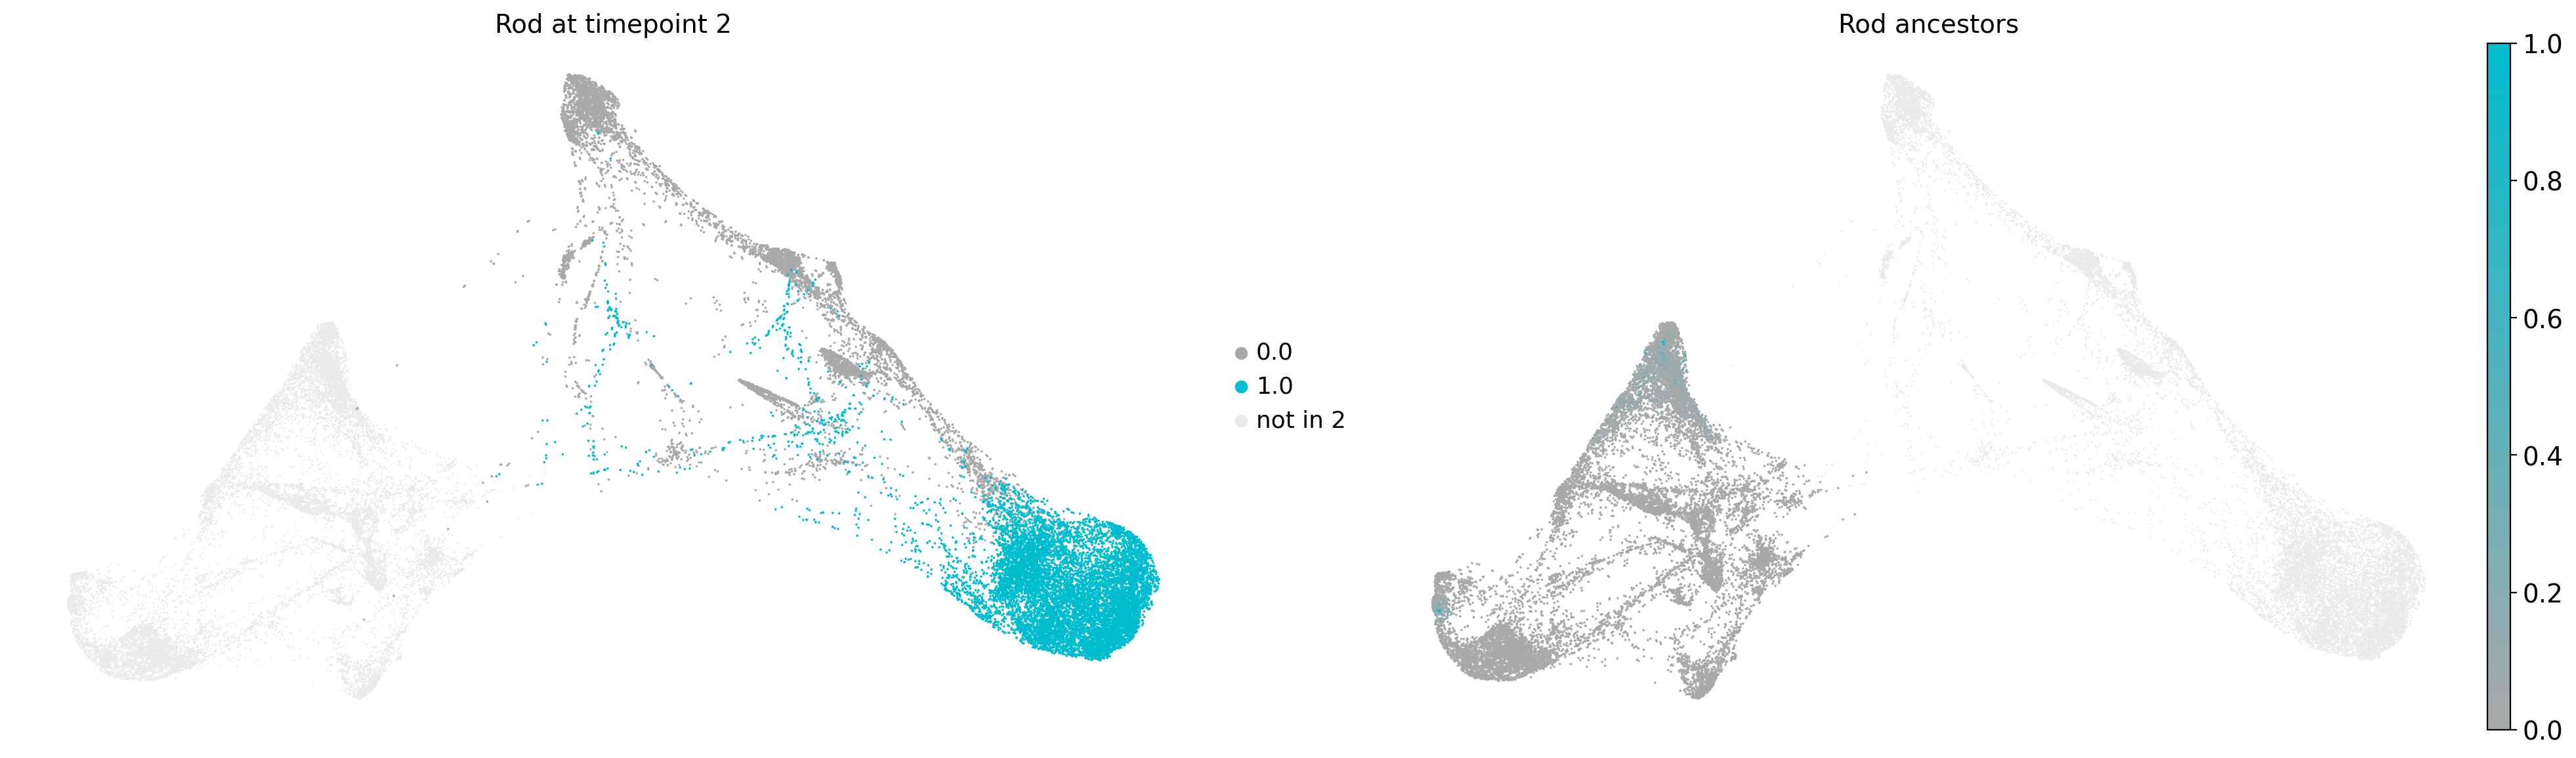

In [66]:
tp.pull(source=1, target=2, data="CellType_combined", subset="Rod") # source target are time points
with plt.rc_context():
    fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
    axes[0] = mtp.pull(
        tp,
        time_points=[2],
        basis="X_draw_graph_fa",
        ax=axes[0],
        return_fig=True,
        title=["Rod at timepoint 2"],
    )
    axes[1] = mtp.pull(
        tp,
        time_points=[1],
        basis="X_draw_graph_fa",
        ax=axes[1],
        return_fig=True,
        title=["Rod ancestors"],
    )

    fig.subplots_adjust(wspace=0.2)
    plt.tight_layout()
    plt.savefig(out_dir + "Rod_ancestors_1-2.pdf", bbox_inches='tight')

/w5home/bmoore/miniconda3/envs/realtime/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


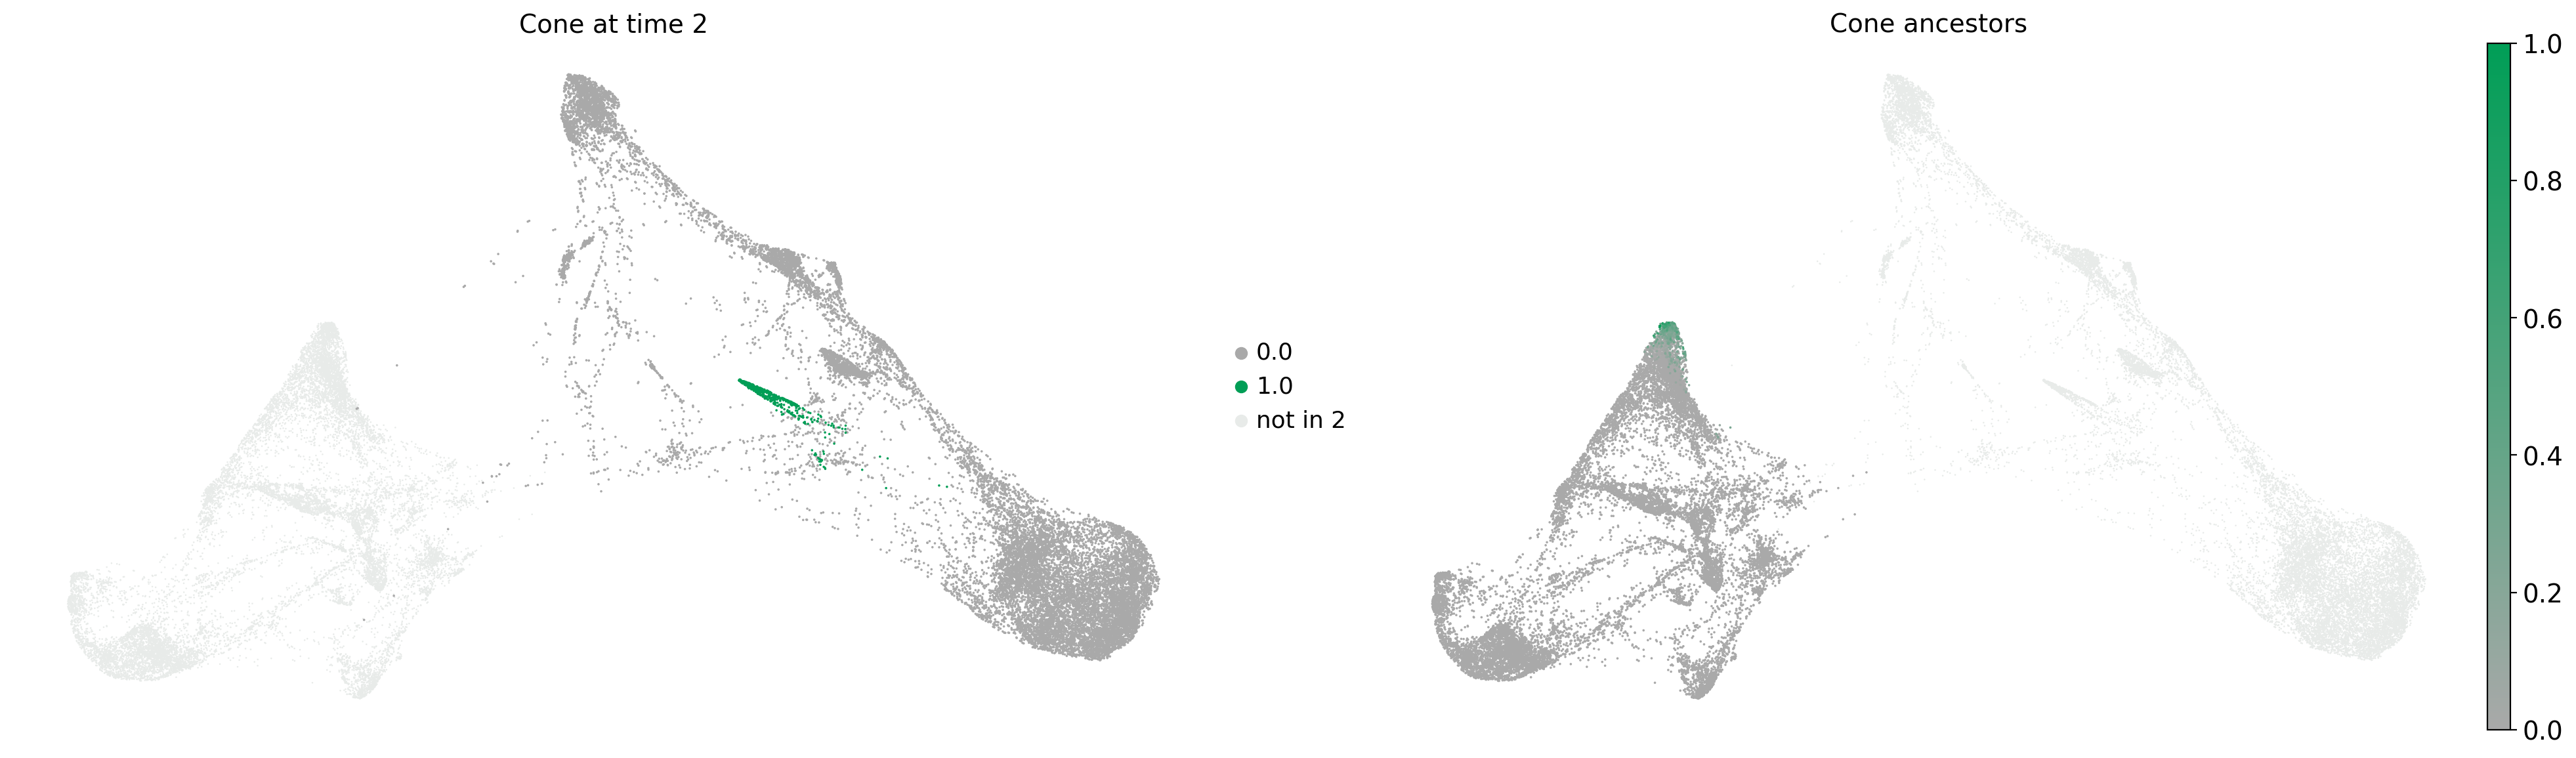

In [69]:
tp.pull(source=1, target=2, data="CellType_combined", subset="Cone") # source target are time points
with plt.rc_context():
    fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

    axes[0] = mtp.pull(
        tp,
        time_points=[2],
        basis="X_draw_graph_fa",
        ax=axes[0],
        return_fig=True,
        title=["Cone at time 2"],
    )
    axes[1] = mtp.pull(
        tp,
        time_points=[1],
        basis="X_draw_graph_fa",
        ax=axes[1],
        return_fig=True,
        title=["Cone ancestors"],
    )

    fig.subplots_adjust(wspace=0.2)
    plt.tight_layout()
    plt.savefig(out_dir + "Cone_ancestors_2-3.pdf", bbox_inches='tight')

/w5home/bmoore/miniconda3/envs/realtime/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


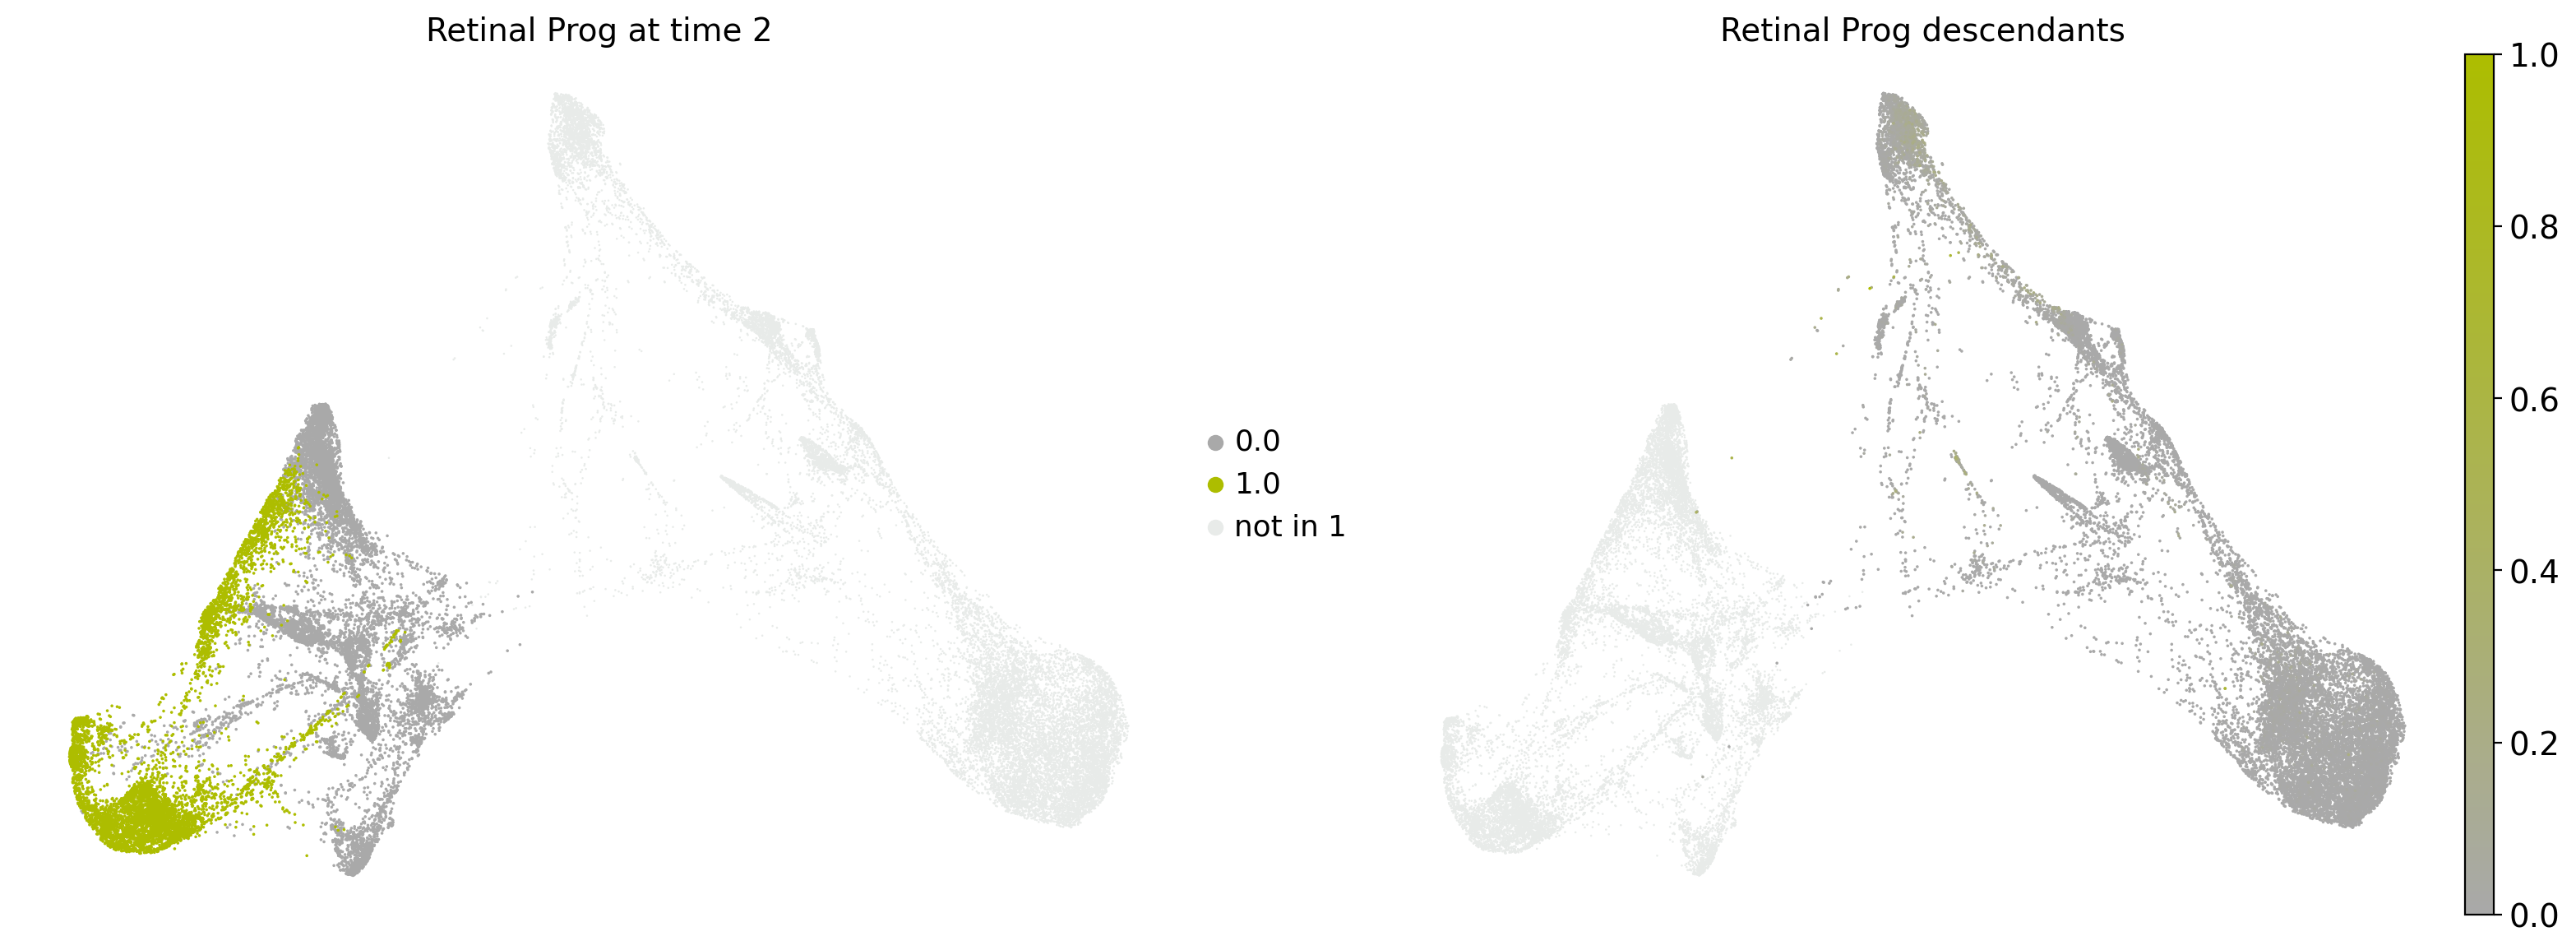

In [70]:
# descendents
tp.push(source=1, target=2, data="CellType_combined", subset="Retinal Prog")
with plt.rc_context():
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

    axes[0] = mtp.push(
        tp,
        time_points=[1],
        basis="X_draw_graph_fa",
        ax=axes[0],
        return_fig=True,
        title=["Retinal Prog at time 2"],
    )
    axes[1] = mtp.push(
        tp,
        time_points=[2],
        basis="X_draw_graph_fa",
        ax=axes[1],
        return_fig=True,
        title=["Retinal Prog descendants"],
    )

    fig.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.savefig(out_dir + "RetinalProg_descendents_2-3.pdf", bbox_inches='tight')

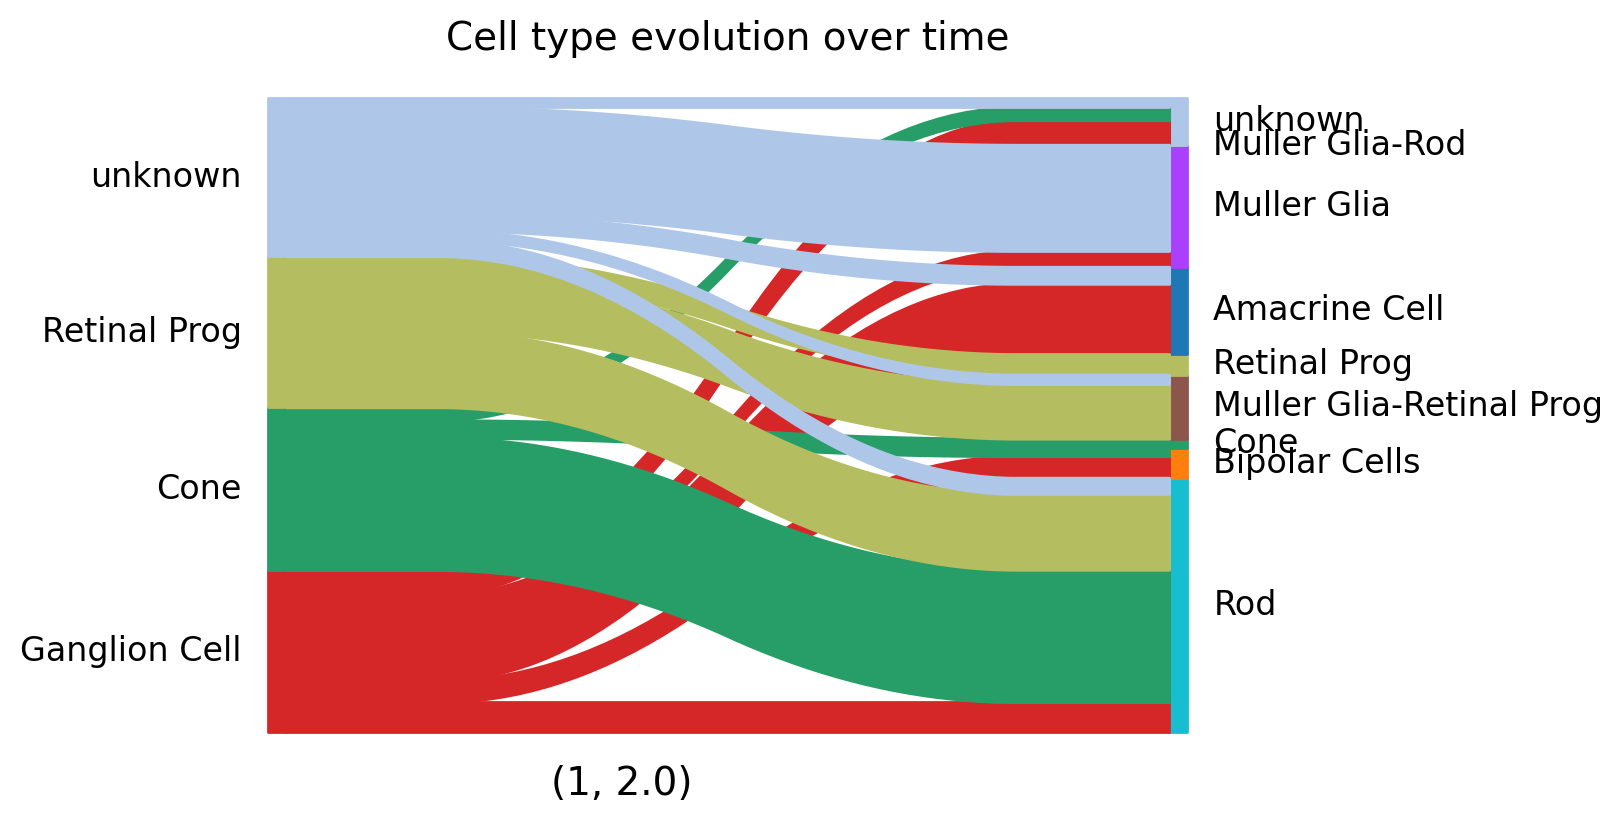

In [74]:
# get dynamics across all time points, we can visualize the cell type evolution
# Sankey diagram allows visualization of flows between cell types
tp.sankey(
    source=1,
    target=2,
    source_groups="CellType_combined",
    target_groups="CellType_combined",
    threshold=0.05,
    forward = True,
)
mtp.sankey(tp, dpi=100, figsize=(8, 4), title="Cell type evolution over time", save=out_dir + "cell_type_evolution.pdf")


In [75]:
# Set up the RealTimeKernel

tmk = RealTimeKernel.from_moscot(tp)

In [76]:
# to get from OT transport maps to a markov chain:
# 1. we sparsify OT transport maps by removing entries below a certain threshold; entropic regularization yields dense matrices which would make CellRank analysis very slow.
# 2. we use OT transport maps and molecular similarity to model transitions across and within time points, respectively.
# 3. we row-normalize the resulting cell-cell transition matrix (including all time points) and construct the Markov chain.

tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

100%|██████████| 1/1 [00:00<00:00, 6177.18time pair/s]


Using automatic `threshold=1.5190312115803684e-13`


RealTimeKernel[n=35990, threshold='auto', self_transitions='all']

Simulating `100` random walks of maximum length `500`


100%|██████████| 100/100 [00:29<00:00,  3.44sim/s]


    Finish (0:00:29)
Plotting random walks


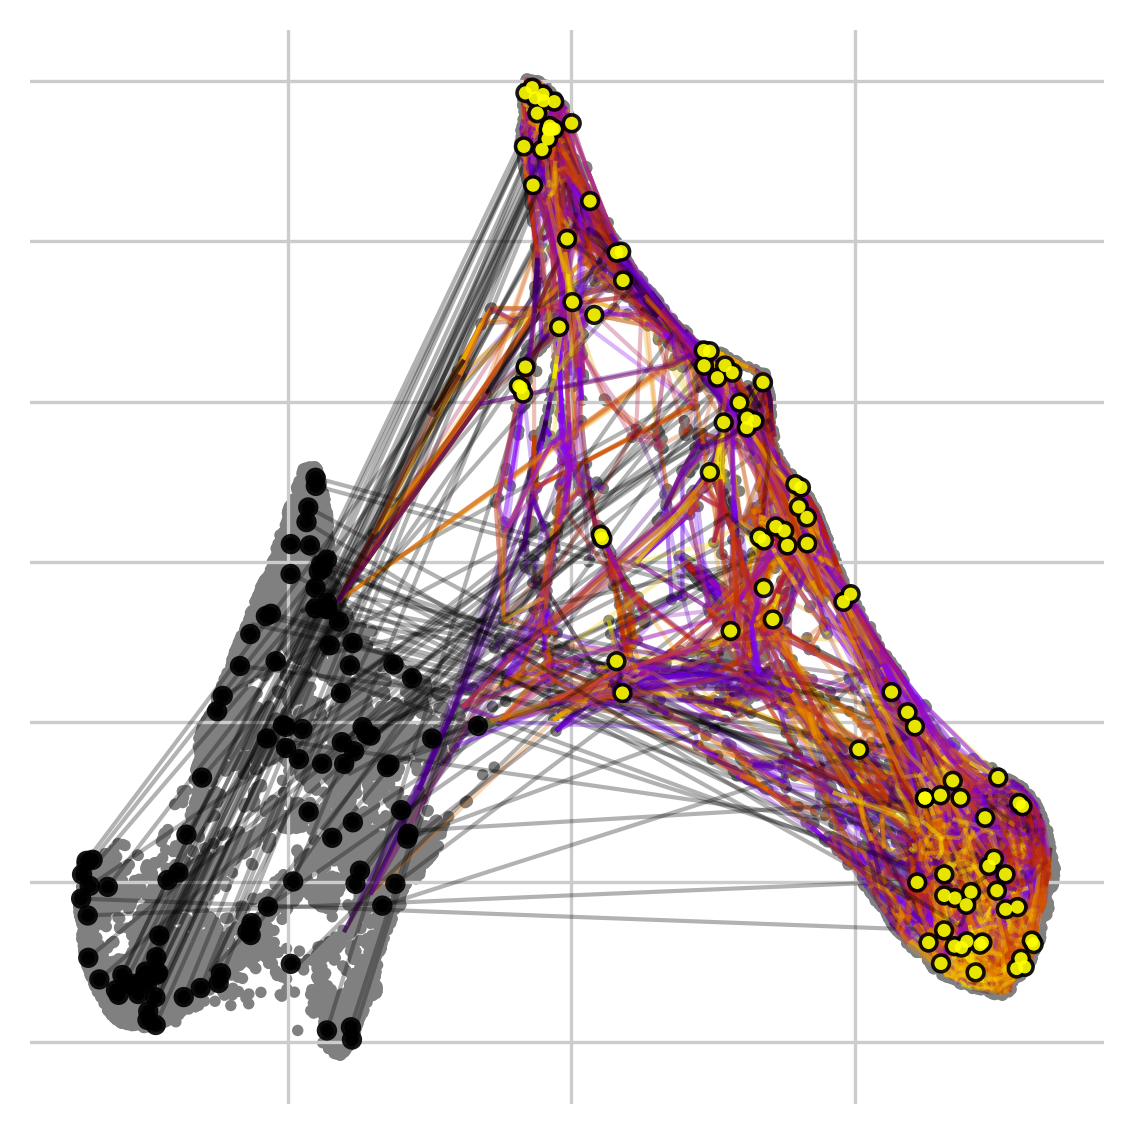

In [77]:
# Visualize the recovered dynamics by sampling random walks.
# This method simulates random walks on the Markov chain defined though the corresponding transition matrix
# Random walks are simulated by iteratively choosing the next cell based on the current cell’s transition probabilities.
with plt.rc_context():
    tmk.plot_random_walks(
        max_iter=500,
        start_ixs={"time": 1},
        basis="X_draw_graph_fa",
        seed=0,
        dpi=150,
        size=30,
    )
    plt.tight_layout()
    plt.savefig(out_dir + "random_walks.pdf", bbox_inches='tight')
    
# Black and yellow dots denote random walks starting and finishing points, respectively.

Computing flow from `Retinal Prog` into `8` cluster(s) in `1` time points
Plotting flow from `Retinal Prog` into `1` cluster(s) in `1` time points


<Figure size 1000x400 with 0 Axes>

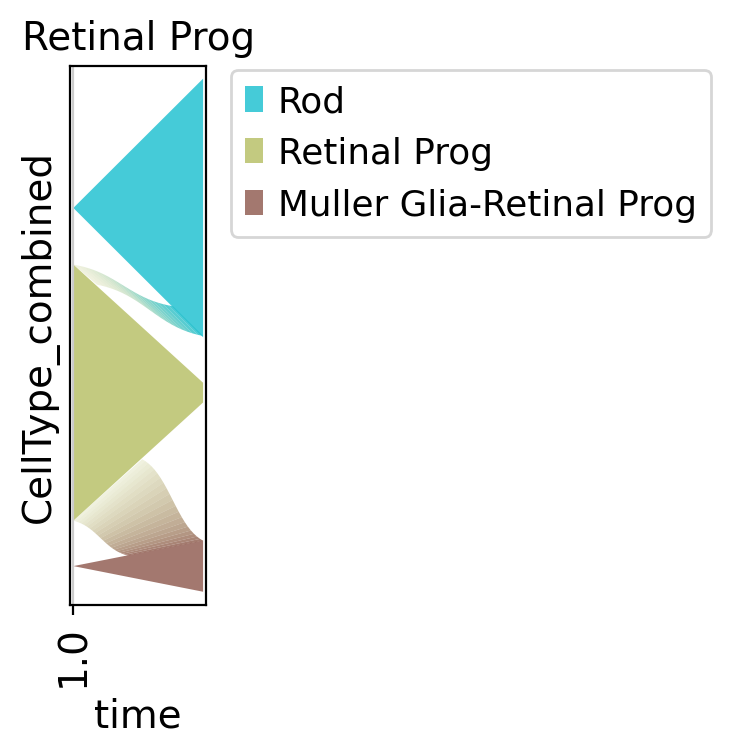

In [83]:
# plot the probability mass flow in time
# Visualize outgoing flow from a cluster of cells
with plt.rc_context():
    plt.figure(figsize=(10,4))
    ax = tmk.plot_single_flow(
        cluster_key="CellType_combined",
        time_key="time",
        cluster="Retinal Prog",
        min_flow=0.1,
        xticks_step_size=4,
        show=False,
        clusters=['Cone', 'unknown', 'Muller Glia-Retinal Prog', 'Rod', 'Muller Glia', 'Bipolar Cells', 'Muller Glia-Rod', 'Amacrine Cell'],
        )

    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.savefig(out_dir + "prob_mass_flow_RetinalProg.pdf", bbox_inches='tight')

Computing flow from `Cone` into `7` cluster(s) in `1` time points
Plotting flow from `Cone` into `2` cluster(s) in `1` time points


<Figure size 1000x400 with 0 Axes>

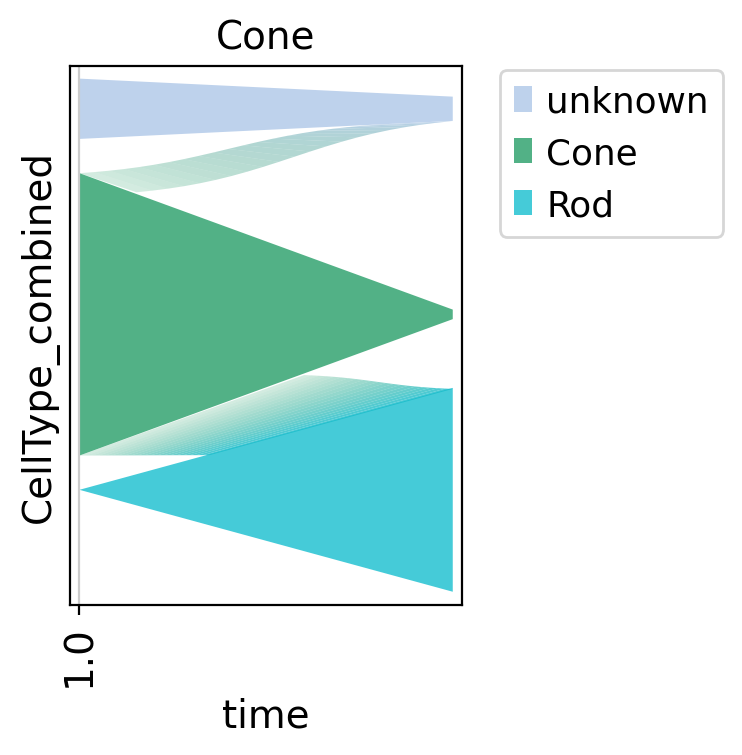

In [84]:
# plot the probability mass flow in time
# Visualize outgoing flow from a cluster of cells
with plt.rc_context():
    plt.figure(figsize=(10,4))
    ax = tmk.plot_single_flow(
        cluster_key="CellType_combined",
        time_key="time",
        cluster="Cone",
        min_flow=0.1,
        xticks_step_size=4,
        show=False,
        clusters=['Cone', 'unknown', 'Muller Glia-Retinal Prog', 'Rod', 'Muller Glia', 'Bipolar Cells', 'Muller Glia-Rod', 'Amacrine Cell'],
        )

    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.savefig(out_dir + "prob_mass_flow_Cone.pdf", bbox_inches='tight')

In [10]:
import subprocess
import sys

In [11]:
in_conda = os.environ.get('CONDA_DEFAULT_ENV') is not None
if in_conda:
    # Use conda list command
    result = subprocess.run(['conda', 'list', '--explicit'], capture_output=True, text=True)
    packages = result.stdout
    # Write the packages to a file
    with open('conda-requirements.txt', 'w') as f:
        f.write(packages)
    print("Package versions have been written to conda-requirements.txt")
else:
    print("Not in a conda environment. Please activate your environment first.")

Package versions have been written to conda-requirements.txt
